# Simulated Data Generator

#### Prerequisite
* Install VowpalWabbit(VW) by following [this instruction](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Building).

In [1]:
# Imports
import json
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from tqdm import tqdm
from vw_offline_utilities import *
from IPython.display import Markdown, display

import warnings
warnings.filterwarnings('ignore')

## Step 1. Generate a Simulated Dataset

In [2]:
# Config File
config_file = r'config_data_generator.json'
configs = json.load(open(config_file, 'r'))
configs = update_params(configs)
np.random.seed(configs['random_state'])

In [3]:
# Generate data
df, context_action_stats = generate_data(**configs)

# Increase the leading gap of the best action
context_actions = summarize_dataset(df, configs, show_results=False)
if configs['increase_winning_margin']!=False:    
    df = increase_lead(df, context_actions, add_value=configs['increase_winning_margin'])

# Finalizing
if configs['center']:
    df['reward'] = df['reward'] - df['reward'].mean()
print('Data Generated')

Data Generated


action                                      \
action                              1     2     3     4     5     6     7   
CallType MediaType NetworkType                                              
1_1      Audio     wifi          1000  1000  1000  1000  1000  1000  1000   
                   wired         1000  1000  1000  1000  1000  1000  1000   
         Video     wifi          1000  1000  1000  1000  1000  1000  1000   
                   wired         1000  1000  1000  1000  1000  1000  1000   
GVC      Audio     wifi          1000  1000  1000  1000  1000  1000  1000   
                   wired         1000  1000  1000  1000  1000  1000  1000   
         Video     wifi          1000  1000  1000  1000  1000  1000  1000   
                   wired         1000  1000  1000  1000  1000  1000  1000   

                                        reward                                \
action                             8         1         2         3         4   
CallType MediaType NetworkType                                                 
1_1      Audio     wifi         1000 -0.079770 -0.011441 -0.049414  0.003009   
                   wired        1000 -0.073771 -0.083822  0.115394 -0.025116   
         Video     wifi         1000  0.010637  0.087003 -0.013323  0.037693   
                   wired        1000 -0.064789 -0.132037  0.067290 -0.024897   
GVC      Audio     wifi         1000 -0.046604  0.051049 -0.030428  0.102287   
                   wired        1000  0.107483 -0.033111  0.012017 -0.065720   
         Video     wifi         1000 -0.001017  0.075097  0.023674  0.079681   
                   wired        1000  0.064993  0.108852  0.077676 -0.003036   

                                                                        
action                                 5         6         7         8  
CallType MediaType NetworkType                                          
1_1      Audio     wifi         0.007617 -0.121527 -0.133022  0.078927  
                   wired        0.059277 -0.022024  0.014036 -0.103404  
         Video     wifi         0.021071 -0.121076  0.040182  0.001840  
                   wired        0.032593  0.069020  0.030677  0.101196  
GVC      Audio     wifi         0.069012 -0.112848 -0.103125 -0.084503  
                   wired       -0.017090 -0.045720 -0.053385  0.002367  
         Video     wifi         0.063469  0.112930  0.022614 -0.098313  
                   wired        0.030930 -0.085936  0.061019 -0.002346

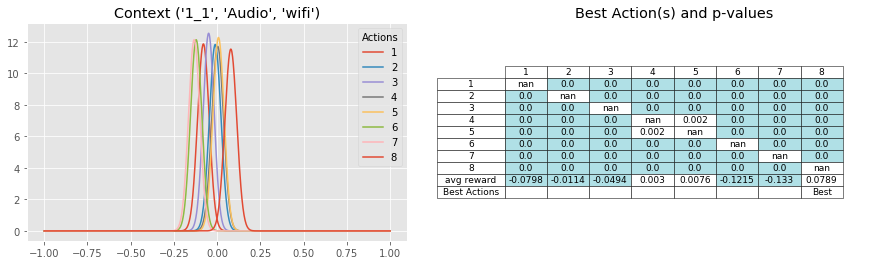

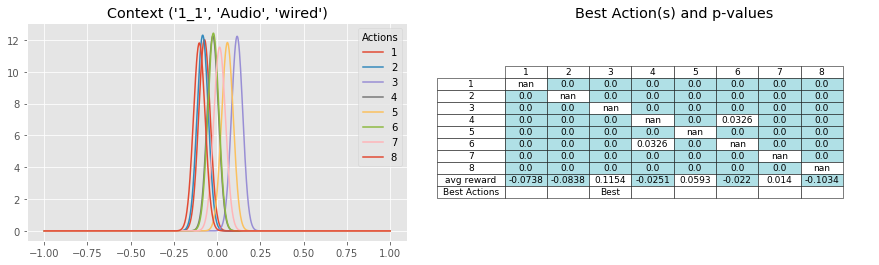

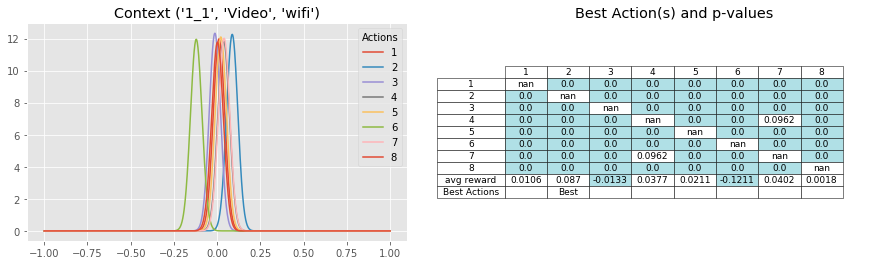

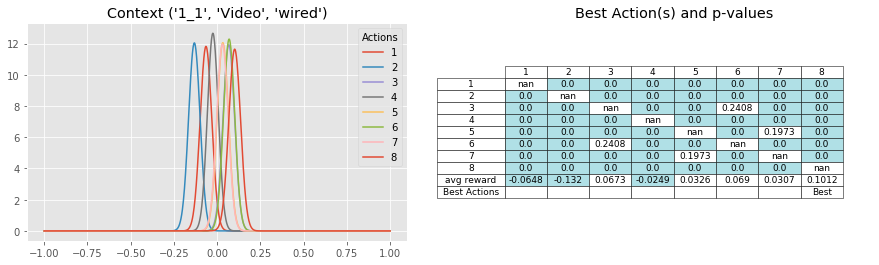

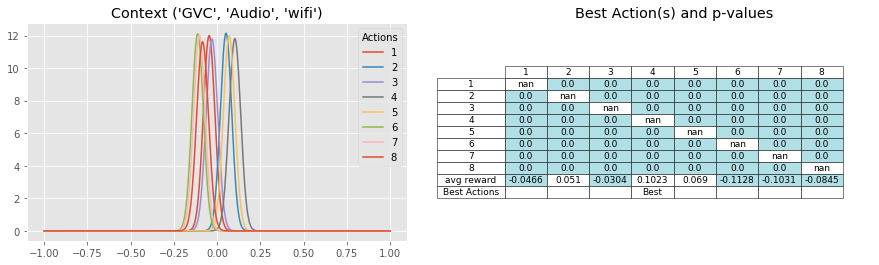

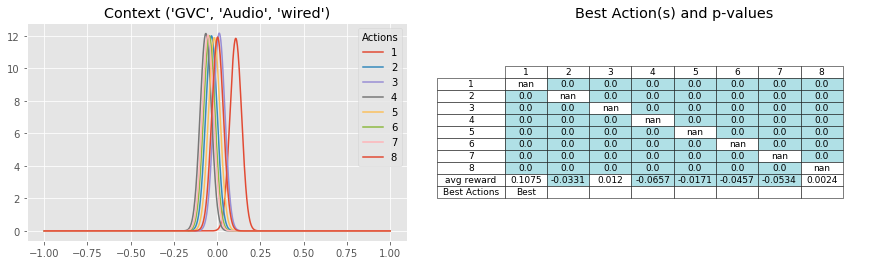

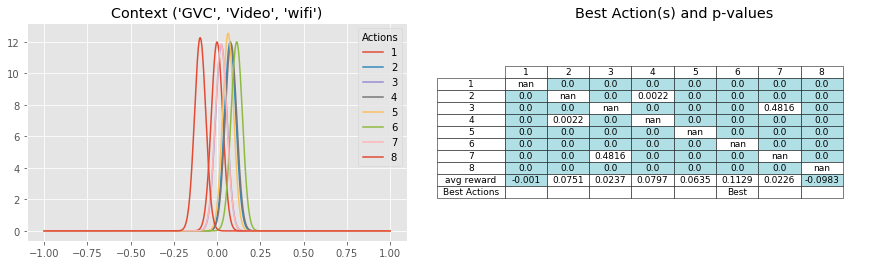

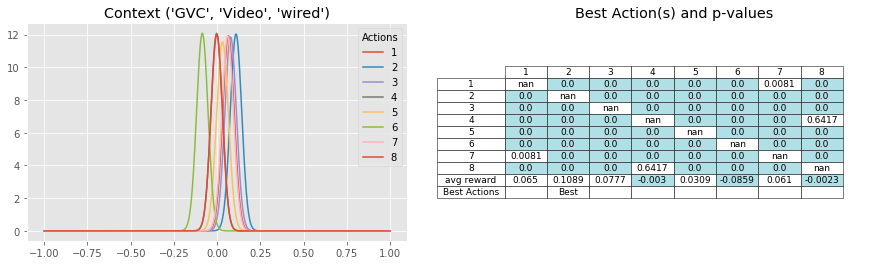

In [4]:
# Summarize data
display(df.groupby(list(configs['contexts'].keys())+['action']).agg({'action': 'count', 'reward': 'mean'}).unstack(-1))
context_actions = summarize_dataset(df, configs, show_results=True)

In [5]:
# Output data
df = df.reset_index().sample(frac=1, random_state=configs['random_state'])
df.to_csv(configs['df_file'], index=False)

## Step 2. Transform to DSLogs and Train a VW Model

### 2.1 Data Overview

In [6]:
%matplotlib notebook

In [7]:
# Column names - context, reward and action columns
context_cols = list(configs['contexts'].keys())
action_col = 'action'
reward_col = 'reward'
df_cols = context_cols + [action_col, reward_col]
idx_cols = context_cols + [action_col]

In [8]:
# Reshape data for the analysis
df.dropna(inplace=True)
for c in idx_cols:
    df[c] =  df[c].astype(str)
df = df.sort_values(idx_cols).set_index(idx_cols)

In [9]:
# Get the space of context and action
contexts = configs['contexts']
actions = [str(x) for x in configs['actions']]
action_mapping = {i: a for i, a in enumerate(actions)}
display(Markdown('**Contexts**:'), dict(contexts))
display(Markdown('**Actions**:'), actions)

**Contexts**:

{'CallType': ['1_1', 'GVC'],
 'MediaType': ['Audio', 'Video'],
 'NetworkType': ['wifi', 'wired']}

**Actions**:

['1', '2', '3', '4', '5', '6', '7', '8']

In [10]:
# Summary
df_summary = df.reset_index().groupby(context_cols+[action_col])[reward_col].mean().unstack(-1)
df_summary.style.apply(lambda x: highlight_optimal(x, is_minimization=False), axis=1)

### 2.2 VW Command Lines
We will specify the training parameters and commands for VowpalWabbit(VW) .

In [11]:
# VW Parameters
tc = configs['model_parameters']
vwc = configs['vw_commands']

# VW Commands
cmd_train_initial = 'vw --dsjson {0} --cb_explore_adf {1} --cb_type {2} {3} -l {4} -f {5} {6}'.format(
    configs['batch_dsjson_path'], vwc['exploration_policy'], vwc['cb_type'], vwc['interactions'], vwc['learning_rate'], configs['model_file'], vwc['other_commands'])
cmd_train_continued = 'vw -i {4} --dsjson {0} --cb_explore_adf {1} --cb_type {2} -l {3} -f {4} {5}'.format(
    configs['batch_dsjson_path'], vwc['exploration_policy'], vwc['cb_type'], vwc['learning_rate'], configs['model_file'], vwc['other_commands'])
cmd_pred_unique_context = 'vw -t -i {0} --dsjson {1} -p {2} -l {3} {4}'.format(
    configs['model_file'], configs['context_dsjson_path'], configs['context_pred_path'], vwc['learning_rate'], vwc['other_commands'])

### 2.3 Transform Data for VW Modeling

VW requires a special data format, DSJson as input. We will transform our tabular data to this format. For details, please visit this [example](https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Conditional-Contextual-Bandit#example-2).

In [12]:
# Unique context
df_contexts = get_unique_context(df_summary, action_col, reward_col, is_minimization=False)
df_contexts_json = transform_dsjson(df_contexts, context_cols, reward_col, action_col, actions, is_minimization=False)
export_dsjson(df_contexts_json, configs['context_dsjson_path'])

# DSLog preview
display(Markdown('**DSLog Preview**'))
display(eval(df_contexts_json['output_json'][0]))

**DSLog Preview**

{'_label_cost': -0.07892743992701208,
 '_label_probability': 0.125,
 '_label_Action': 8,
 '_labelIndex': 7,
 'o': [{'EventId': 'EventId_9c123d8f0cc64c118242428d9d36d731',
   'v': -0.07892743992701208}],
 'Timestamp': '2020-02-12T06:41:48.862063Z',
 'Version': '1',
 'EventId': 'EventId_9c123d8f0cc64c118242428d9d36d731',
 'a': [8, 2, 3, 4, 5, 6, 7, 1],
 'c': {'Features': [{'CallType': '1_1'},
   {'MediaType': 'Audio'},
   {'NetworkType': 'wifi'}],
  '_multi': [{'id': {'0': 1}},
   {'id': {'1': 1}},
   {'id': {'2': 1}},
   {'id': {'3': 1}},
   {'id': {'4': 1}},
   {'id': {'5': 1}},
   {'id': {'6': 1}},
   {'id': {'7': 1}}]},
 'p': [0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125],
 'm': 'v1'}

### 2.4 Train a Model with VW 

We will train a Contextual Bandit model with VW in this section. We can monitor the accuracy of exploit actions in the mean time. The training logs will be saved in a \log subfolder.

<IPython.core.display.Javascript object>


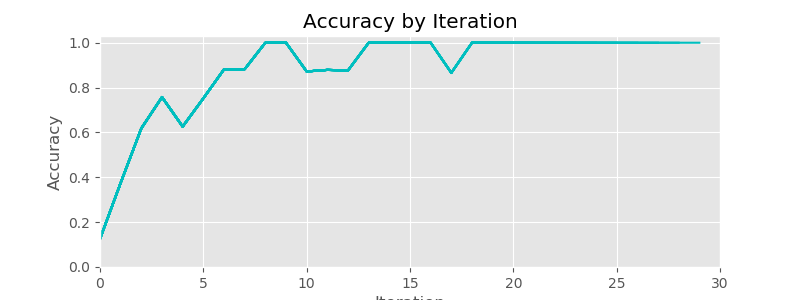

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:02<00:00,  6.23s/it]


In [13]:
# Prep plot
df_batch_accuracy = [np.nan]*tc['iterations']
fig, ax = init_plot(tc['iterations'])

# Training
trajectory = pd.DataFrame()
for i in tqdm(range(tc['iterations'])):
    # Select data
    df_batch = select_data(i, df, df_contexts, configs, action_mapping, context_cols, action_col, reward_col)    
    trajectory = trajectory.append(df_batch)
    # Export to dsjson format
    df_batch_json = transform_dsjson(df_batch, context_cols, reward_col, action_col, actions, is_minimization=False)
    export_dsjson(df_batch_json, configs['batch_dsjson_path'])
    # Plot
    df_batch_compare = pd.merge(
        df_batch.loc[df_batch['action_prob']==df_batch['action_prob'].max(), idx_cols], df_contexts, 
        how='left', left_on=context_cols, right_on=context_cols, suffixes=['_pred', '_opt'])
    df_batch_accuracy[i] = (df_batch_compare['action_pred']==df_batch_compare['action_opt']).mean()
    plt_dynamic(fig, ax, df_batch_accuracy)
    # Update model
    if i == 0:
        job = subprocess.Popen(cmd_train_initial)
        job.wait()
    else:
        job = subprocess.Popen(cmd_train_continued)
        job.wait() 
    # Predict with new model
    job = subprocess.Popen(cmd_pred_unique_context)
    job.wait() 
    # Keep all inputs by renaming them
    new_name = configs['batch_dsjson_path'].replace('.json', '{0}.json'.format(i))
    if os.path.exists(new_name):
        os.remove(new_name)
    os.rename(configs['batch_dsjson_path'], new_name)

### 2.5 Predictions and Regret

We can compare the model predictions with the optimal (ground truth) to validate that the model is taking the best actions.

We will also look at the average regret (distance from the optimal) over the training session.

In [14]:
# Compare the final prediction with the optimal value
pred_context = load_pred_context(configs['pred_file'], df_contexts, context_cols, action_mapping)
df_compare = pd.merge(df_contexts, pred_context, left_on=context_cols, right_on=context_cols, how='left')
df_compare.rename(columns={action_col: 'optimal_action'}, inplace=True)
df_compare = df_compare[context_cols + ['optimal_action', 'exploit_action']].astype(str)
df_compare.style.apply(lambda x: highlight_suboptimal(x, df_compare['optimal_action'], ['exploit_action']))

,CallType,MediaType,NetworkType,optimal_action,exploit_action
0,1_1,Audio,wifi,8,8
1,1_1,Audio,wired,3,3
2,1_1,Video,wifi,2,2
3,1_1,Video,wired,8,8
4,GVC,Audio,wifi,4,4
5,GVC,Audio,wired,1,1
6,GVC,Video,wifi,6,6
7,GVC,Video,wired,2,2


The table above shows that the model predictions match optimal actions in all contexts. 

Next, we'll look at the regret by context. Regret is defined as the distance between the optimal reward and that from the chosen action. So when then optimal action is learned, there will be no regret. In this particular example, as we used _epsilon 0.2_, which means that we always randomly explore for 20% of the population, so the regret will never be 0 but stay at a low level.

<IPython.core.display.Javascript object>


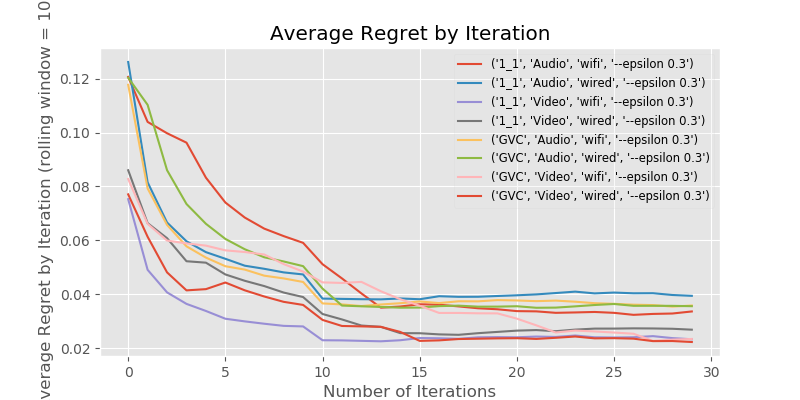

In [15]:
# Regret by iteration
regret = get_regrets(trajectory, df_contexts, context_cols, reward_col, vwc['exploration_policy'], is_minimization=False)

# Plot Regret by context
groups = context_cols + ['exploration', 'n_iteration']
plot_regrets(regret, groups, rolling_window=10)

---